# Classifiers using neuro-imaging data

In [1]:
import pandas as pd
import numpy as np
from numpy import random, arange
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

# Import relevant sklearn class/function related to evaluation
import sklearn.metrics
from imblearn.under_sampling import RandomUnderSampler

#Smote oversampling 
import smote_variants as sv

## Data Pre-Processing

In [2]:

img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [3]:

img_adni2.drop(["LONISID", "IMAGETYPE", "LHIPQC", "RHIPQC", "ST131HS", "ST132HS", "ST133HS", "ST134HS", "ST135HS", "ST136HS", "ST137HS", "ST138HS", "ST139HS", "ST140HS", "ST141HS", "ST142HS", "ST143HS", "ST144HS", "ST145HS", "ST146HS"], inplace=True, axis=1)
img_adni3.drop(["HIPPOQC"], axis=1, inplace=True)

In [4]:
colNames2 = []
for colName2 in img_adni2.columns:
    if not colName2 in img_adni1.columns:
        #print(colName2)
        if not (colName2 == "VISCODE2" or colName2 =="COLPROT"):
            colNames2.append(colName2)

print("---")
for colName3 in img_adni3.columns:
    if not colName3 in img_adni2.columns:
        print(colName3)
print("---")
colNames = []
for colName1 in img_adni1.columns:
    if not colName1 in img_adni2.columns:
        #print(colName1)
        colNames.append(colName1)


img_adni1.drop(colNames, inplace=True, axis=1)
img_adni2.drop(colNames2, inplace=True, axis=1)
img_adni3.drop(colNames2, axis=1, inplace=True)

---
---


In [5]:
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)
dx1= dx[(dx["Phase"] == "ADNI1")]
dx2= dx[(dx["Phase"] == "ADNI2") | (dx["Phase"] == "ADNIGO")]
dx3= dx[(dx["Phase"] == "ADNI3")]


In [26]:
img_dx2go.head()

,COLPROT,RID,VISCODE,VISCODE2,EXAMDATE,VERSION,LONIUID,IMAGEUID,RUNDATE,STATUS,...,ST149SV,ST150SV,ST151SV,ST152SV,ST153SV,ST154SV,ST155SV,update_stamp,DXCHANGE,PTID
0,ADNI2,21,v11,m84,2012-10-04,2012-10-24,169744.0,340931,2012-10-24,complete,...,384420.0,196942.0,197448.0,394390.0,142785.0,527205.0,869951.0,2019-11-14 14:34:00.0,1.0,011_S_0021
1,ADNIGO,21,nv,m60,2010-10-08,2012-02-10,93190.0,222684,2012-02-10,complete,...,384534.0,205140.0,204958.0,410098.0,146962.0,531496.0,885815.0,2019-11-14 14:34:00.0,1.0,011_S_0021
2,ADNIGO,21,nv,m60,2010-10-08,2012-02-10,93187.0,222738,2012-02-10,partial,...,375077.0,210619.0,208063.0,418682.0,146446.0,521523.0,883558.0,2019-11-14 14:34:00.0,1.0,011_S_0021
3,ADNI2,21,v06,m72,2011-10-13,2012-04-05,125206.0,265250,2012-04-05,complete,...,366238.0,208414.0,209070.0,417484.0,144658.0,510896.0,877214.0,2019-11-14 14:34:00.0,1.0,011_S_0021
4,ADNI2,21,v21,m96,2013-10-17,2013-12-23,204109.0,398269,2013-12-23,partial,...,373956.0,200248.0,198403.0,398652.0,141727.0,515683.0,860546.0,2019-11-14 14:34:00.0,1.0,011_S_0021


In [12]:
dx1['PTID']

0       011_S_0002
1       011_S_0002
2       011_S_0003
3       011_S_0003
4       011_S_0003
           ...    
3863    127_S_1427
3864    127_S_1427
3865    127_S_1427
3866    128_S_1430
3867    128_S_1430
Name: PTID, Length: 3868, dtype: object

In [23]:
img_dx1 = pd.merge(img_adni1, dx1[["VISCODE", "RID", "DXCURREN", "PTID"]], left_on=["VISCODE","RID"], right_on=["VISCODE","RID"])
img_dx2go = pd.merge(img_adni2, dx2[["VISCODE2", "RID", "DXCHANGE",'PTID']], left_on=["VISCODE2","RID"], right_on=["VISCODE2","RID"])
img_dx3 = pd.merge(img_adni3, dx3[["VISCODE2", "RID", "DIAGNOSIS", "PTID"]], left_on=["VISCODE2","RID"], right_on=["VISCODE2","RID"])

In [24]:
(img_dx1['PTID'].append(img_dx2go['PTID'].append(img_dx3['PTID']))).nunique()

1742

In [28]:
img_dx1.rename(columns={"VISCODE": "VISCODE2"})
img_dx2go.drop(["COLPROT"], inplace=True, axis=1)
img_dx3.drop(["COLPROT"], inplace=True, axis=1)

In [29]:
img = img_dx1.append(img_dx2go.append(img_dx3))

In [31]:
firstvisits = ~img.duplicated(subset=['PTID'], keep='first')
img = img.loc[firstvisits].copy()

In [34]:
img

,RID,VISCODE,EXAMDATE,VERSION,LONIUID,IMAGEUID,RUNDATE,STATUS,OVERALLQC,TEMPQC,...,ST152SV,ST153SV,ST154SV,ST155SV,update_stamp,DXCURREN,PTID,VISCODE2,DXCHANGE,DIAGNOSIS
0,15,m36,2009-04-27,2013-08-07,66778.0,160866,2013-08-07,partial,Pass,Pass,...,429929.0000,167857.0,534752.0000,9.092360e+05,2016-02-02 09:34:17.0,1.0,100_S_0015,NaN,NaN,NaN
5,30,m18,2007-04-26,2014-01-06,30858.0,118835,2014-01-06,partial,Partial,Fail,...,386915.0000,147415.0,561204.0000,1.027810e+06,2016-02-02 09:34:17.0,3.0,023_S_0030,NaN,NaN,NaN
9,31,m12,2006-10-30,2013-05-06,21475.0,118846,2013-05-06,partial,Fail,Fail,...,354537.0000,152878.0,542742.0000,9.147000e+05,2016-02-02 09:34:17.0,1.0,023_S_0031,NaN,NaN,NaN
12,58,m24,2007-12-06,2013-05-06,43409.0,87046,2013-05-06,partial,Partial,Pass,...,431821.0000,173206.0,593341.0000,9.714780e+05,2016-02-02 09:34:17.0,1.0,023_S_0058,NaN,NaN,NaN
15,61,m12,2006-12-06,2013-05-06,23481.0,118858,2013-05-06,partial,Pass,Pass,...,398095.0000,142984.0,544818.0000,9.098740e+05,2016-02-02 09:34:17.0,1.0,023_S_0061,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,7029,sc,2022-01-10,2022-03-10,1095392.0,1532649,2022-03-10,complete,Pass,Pass,...,442581.8942,49614.0,586429.8798,9.421738e+05,2022-08-26 14:42:03.0,NaN,067_S_7029,sc,NaN,2.0
1856,7033,sc,2022-01-03,2022-03-02,1092990.0,1529914,2022-03-02,partial,NaN,NaN,...,396638.7168,49607.0,530439.9994,8.382687e+05,2022-08-26 14:42:03.0,NaN,067_S_7033,sc,NaN,3.0
1857,7044,sc,2022-02-21,2022-06-28,1106750.0,1546901,2022-06-28,partial,NaN,NaN,...,369332.0396,42613.0,524582.6837,8.829197e+05,2022-08-26 14:42:03.0,NaN,036_S_7044,sc,NaN,2.0
1858,7048,sc,2022-03-18,2022-05-19,1115524.0,1558064,2022-05-19,partial,NaN,NaN,...,395594.8667,55446.0,556212.4274,8.836193e+05,2022-08-26 14:42:03.0,NaN,011_S_7048,sc,NaN,1.0


<AxesSubplot:xlabel='DXCURREN', ylabel='Probability'>

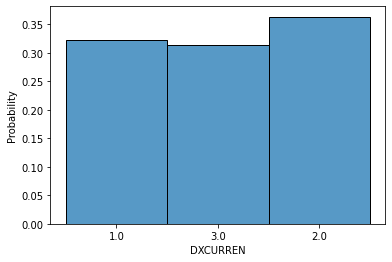

In [55]:

sns.histplot(img_dx1['DXCURREN'].astype(str), stat='probability')

<AxesSubplot:xlabel='DIAGNOSIS', ylabel='Probability'>

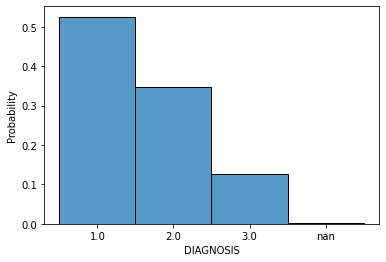

In [56]:
sns.histplot(img_dx3['DIAGNOSIS'].astype(str), stat='probability')

<AxesSubplot:xlabel='DXCHANGE', ylabel='Probability'>

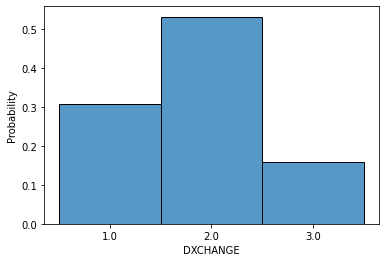

In [58]:
img2gocurren = img_dx2go.copy()
img2gocurren[(img2gocurren["DXCHANGE"] == 1) | (img2gocurren["DXCHANGE"] == 7) |(img2gocurren["DXCHANGE"] == 9)] = 1
img2gocurren[(img2gocurren["DXCHANGE"] == 2) | (img2gocurren["DXCHANGE"] == 4) |(img2gocurren["DXCHANGE"] == 8)] = 2
img2gocurren[(img2gocurren["DXCHANGE"] == 3) | (img2gocurren["DXCHANGE"] == 5) |(img2gocurren["DXCHANGE"] == 6)] = 3

sns.histplot(img2gocurren['DXCHANGE'].astype(str), stat='probability')

In [41]:
len(adni_merge)

16222